In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
def printImg(img):
    %matplotlib inline
    plt.imshow(img, cmap = cm.Greys)
    plt.show()

### Chargement des données

In [3]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
data = fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = data


### 1. Regression linéaires multiples
Je prends les données, je les transforment en un array de dimension 1, ensuite je les centre et normalise.

In [4]:
from statsmodels.regression.linear_model import OLS
X = np.reshape(X_train,(X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X = X/256
X = X-0.5
m = OLS(y_train,X)
results = m.fit()
su = results.summary()

In [5]:
print(su)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                -637.946
Model:                            OLS   Adj. R-squared (uncentered):           -646.405
Method:                 Least Squares   F-statistic:                             -75.41
Date:                Sun, 26 Dec 2021   Prob (F-statistic):                        1.00
Time:                        18:07:11   Log-Likelihood:                     -1.0398e+05
No. Observations:               60000   AIC:                                  2.095e+05
Df Residuals:                   59216   BIC:                                  2.166e+05
Df Model:                         784                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

On observe bien que la valeur du R² est très éloignée de 1 . Le modèle est donc complètement inutilisable.

Une autre méthode serait peut être de ne pas travailler sur chaque pixel, mais sur la somme des lignes ou des collones. On va tenter les deux opérations:

#### 1.1: Somme des lignes

In [80]:
def lineSum(X_data):
    X_out = np.zeros((X_data.shape[0],X_data.shape[1],1))
    for i in range (X_out.shape[0]):
        img = X_data[i]
        outimg = np.array([np.sum(line) for line in img])
        outimg = np.reshape(outimg,(outimg.shape[0],1))
        outimg = outimg/(outimg.shape[0])
        X_out[i] = outimg
    return X_out

In [81]:
X_lined = lineSum(X_train)

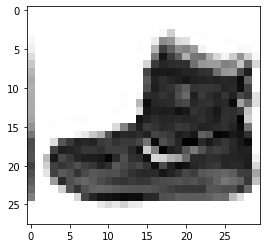

In [82]:
img_test = X_lined[0]
img_test = np.concatenate((img_test,np.zeros((28,1))),axis=1)
img_test = np.concatenate((img_test,X_train[0]),axis=1)
printImg(img_test)

In [85]:
X_l = np.reshape(X_lined,(X_lined.shape[0],X_lined.shape[1]*X_lined.shape[2]))
X_l = X_l/256
X_l = X_l-0.5
m = OLS(y_train,X_l)
results = m.fit()
su = results.summary()
print(su)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                -994.857
Model:                            OLS   Adj. R-squared (uncentered):           -995.322
Method:                 Least Squares   F-statistic:                             -2140.
Date:                Sun, 26 Dec 2021   Prob (F-statistic):                        1.00
Time:                        18:52:41   Log-Likelihood:                     -1.1730e+05
No. Observations:               60000   AIC:                                  2.346e+05
Df Residuals:                   59972   BIC:                                  2.349e+05
Df Model:                          28                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

La version de la somme d'une ligne est moins efficace que la version pixel par pixel.

#### 1.1: Somme des collones

In [86]:
def columnSum(X_data):
    X_out = np.zeros((X_data.shape[0],1,X_data.shape[1]))
    for i in range (X_out.shape[0]):
        img = X_data[i].T
        outimg = np.array([np.sum(line) for line in img])
        outimg = np.reshape(outimg,(outimg.shape[0],1))
        outimg = outimg/(outimg.shape[0])
        X_out[i] = outimg.T
    return X_out

In [88]:
X_col = columnSum(X_train)

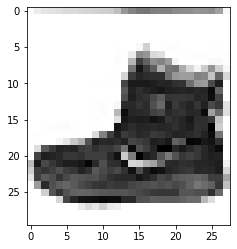

In [90]:
img_test = X_col[0]
img_test = np.concatenate((img_test,np.zeros((1,28))),axis=0)
img_test = np.concatenate((img_test,X_train[0]),axis=0)
printImg(img_test)

In [91]:
X_c = np.reshape(X_col,(X_col.shape[0],X_col.shape[1]*X_col.shape[2]))
X_c = X_c/256
X_c = X_c-0.5
m = OLS(y_train,X_c)
results = m.fit()
su = results.summary()
print(su)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):               -1252.020
Model:                            OLS   Adj. R-squared (uncentered):          -1252.605
Method:                 Least Squares   F-statistic:                             -2140.
Date:                Sun, 26 Dec 2021   Prob (F-statistic):                        1.00
Time:                        18:56:32   Log-Likelihood:                     -1.2419e+05
No. Observations:               60000   AIC:                                  2.484e+05
Df Residuals:                   59972   BIC:                                  2.487e+05
Df Model:                          28                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

On observe qu'ici aussi le resulat est plus mauvais que celui du pixel par pixel.

Il me semble logique que les deux projections ont un moins bon résultat que la version pixel par pixel. En effet la perte d'information  faite lors des projections est bien trop grande. Si l'on voulait éviter ce genre de problèmes, il vaudrait mieux faire une ACP ou une ACI.

### 1. ACP


#### Prétraitement des donnés

In [15]:
from sklearn.preprocessing import StandardScaler
X = np.reshape(X_train,(X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X = X/256
X = X-0.5
scaler = StandardScaler()
z = scaler.fit_transform(X)

#### ACP


In [18]:
from sklearn.decomposition import PCA
pca = PCA()
print(pca)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)


In [24]:
pca.fit_transform(z)

array([[-8.01174771e-01,  2.08667487e+01, -1.29451358e+01, ...,
        -1.10270152e-01, -1.40782640e-02,  5.94582173e-02],
       [ 1.70742060e+01, -4.96851249e+00, -2.07781957e+00, ...,
         1.43979158e-02, -8.79639960e-03, -6.54577116e-03],
       [-9.60164085e+00, -1.22961007e+01,  1.08228415e+00, ...,
         3.17106651e-03,  7.92388464e-03,  1.49373374e-02],
       ...,
       [ 9.37766441e+00, -1.31058579e+01, -8.83829805e+00, ...,
         2.72782448e-02, -4.49627587e-04,  5.02273514e-04],
       [-9.64563637e+00, -7.09528763e+00,  6.94533514e+00, ...,
         4.72269934e-03,  7.98533308e-03, -1.81433145e-03],
       [-2.13170793e+01, -1.74136729e+00,  5.47629241e+00, ...,
        -1.03787437e-01, -1.73135384e-02, -1.01755812e-02]])

In [28]:
print(pca.n_components_)

784


In [29]:
print(pca.explained_variance_)

[1.73137896e+02 1.13012603e+02 4.28163365e+01 3.98959607e+01
 3.17908401e+01 2.36733644e+01 2.15410670e+01 1.81393468e+01
 1.32704963e+01 1.03336329e+01 9.17376265e+00 7.54506218e+00
 7.10661624e+00 6.75040337e+00 5.82527662e+00 5.72584171e+00
 5.18669801e+00 4.95116213e+00 4.87607894e+00 4.58085356e+00
 4.10343340e+00 4.00725656e+00 3.71256369e+00 3.52868326e+00
 3.43949691e+00 3.27000669e+00 3.12303695e+00 3.06192229e+00
 2.96094002e+00 2.92849545e+00 2.84689256e+00 2.75675535e+00
 2.63460955e+00 2.59449221e+00 2.57190118e+00 2.48928424e+00
 2.39285061e+00 2.32586007e+00 2.23204333e+00 2.21928761e+00
 2.16063196e+00 2.10221955e+00 2.05704119e+00 1.99554846e+00
 1.94060149e+00 1.88353239e+00 1.86575542e+00 1.79051386e+00
 1.74106688e+00 1.69390146e+00 1.65003154e+00 1.62447385e+00
 1.59068789e+00 1.57278982e+00 1.55916668e+00 1.52201618e+00
 1.47811201e+00 1.44984072e+00 1.41420988e+00 1.38678293e+00
 1.37072550e+00 1.34334980e+00 1.32729260e+00 1.28286002e+00
 1.26238820e+00 1.251657

In [30]:
print(pca.explained_variance_ratio_.sum())

1.0


On récupère les valeurs propres

In [32]:
eigval = pca.explained_variance_
p = X.shape[1]

On dessine l'eboulie des valeurs propres : 

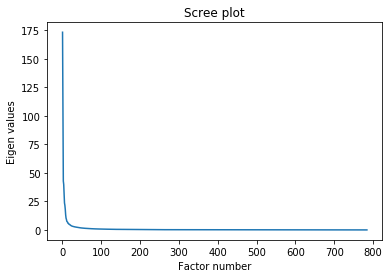

In [39]:
import numpy as np
%matplotlib inline
#scree plot
plt.plot(np.arange(1,p+1),eigval) 
plt.title("Scree plot") 
plt.ylabel("Eigen values") 
plt.xlabel("Factor number") 
plt.show()

In [47]:
n_components = 20
pca = PCA(n_components=n_components)
pca_wine = pca.fit_transform(z)
total_variance = pca.explained_variance_ratio_.sum()
print('Total Explained Variance: ', total_variance)
print(pca_wine.shape)

Total Explained Variance:  0.7006669293158543
(60000, 20)


Avec 20 axes, ce qui permet de garder 70% de variance totale.

### 2.ACI

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import warnings
warnings.filterwarnings("ignore")

In [13]:
lda = LinearDiscriminantAnalysis(n_components=20)
X = np.reshape(X_train,(X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X = X/256
X = X-0.5
X_r2 = lda.fit(X, y_train).transform(X)

In [14]:
# Percentage of variance explained for each components
print(
    "explained variance ratio: %s"
    % str(lda.explained_variance_ratio_)
)

explained variance ratio (first two components): [0.44566231 0.21978128 0.09304346 0.07341999 0.06094608 0.04322803
 0.0379874  0.01602057 0.00991087]


NameError: name 'colors' is not defined

<Figure size 432x288 with 0 Axes>